In [39]:
from crpropa import *
from crpropa import Module
from MonopolePropagationBP import MonopolePropagationBP
from MonopolePropagationCK import MonopolePropagationCK
from MonopoleRadiation import MonopoleRadiation
import math
import numpy as np

In [40]:
def analytical_solution(p_z, r_g_0, t):
    # calculate the time stamps similar to that used in the numerical simulation
    # shift the phase so that the analytical solution
    # also starts at (0,0,0) with in the direction (p_x,p_y,p_z)
    
    #helper values
    p = np.sqrt((energy + m*c_squared)**2 - (m*c_squared)**2)/c_light
    Z = -1 * g * B / m
    uz = p * p_z / m
    up = p * (1-p_z**2)**(1/2.) / m
    A = np.sqrt(c_squared + up**2 + uz**2)

    z_ana = A * c_light / Z - c_light / Z * np.sqrt((Z * t - uz)**2 + c_squared + up**2)
    
    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5
    
    #Helper values
    alpha = q* eplus * c_light/g
    beta = Z / g / B / c_light * (m*c_squared + energy + g*B*A*c_light/Z)
    delta = c_squared + up**2
    x = Z*t - uz
    phi = -alpha *np.log(np.sqrt(delta+x**2)+x) - alpha*beta*(np.arctan(beta * x / (np.sqrt((delta-beta**2)*(delta+x**2)))) + np.arctan(x/np.sqrt(delta-beta**2)))/(np.sqrt(delta-beta**2))
    x0 = -uz
    phi0 = -alpha *np.log(np.sqrt(delta+x0**2)+x0) - alpha*beta*(np.arctan(beta * x0 / (np.sqrt((delta-beta**2)*(delta+x0**2)))) + np.arctan(x0/np.sqrt(delta-beta**2)))/(np.sqrt(delta-beta**2))
    phi = phi - phi0 - 3*math.pi/4
    
    # at these trajectory lengths, the numerical solutions are known
    x_ana = r_g*np.cos(phi)
    y_ana = -1*r_g*np.sin(phi)
    
    return x_ana, y_ana, z_ana / pc

In [41]:
class MyTrajectoryOutput(Module):
    def __init__(self, fname):
        Module.__init__(self)
        #self.fout = open(fname, 'w')
        #self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(1, 0, 0, 0))
    def process(self, c):
        i = 1
        v = c.current.getVelocity()
        x = v.x
        y = v.y
        z = v.z
        #print(c.current.getEnergy() / EeV)
        #self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(i, x, y, z))
    def close(self):
        pass
        #self.fout.close()

In [42]:
import numpy as np
from crpropa import *
import math

# Gyro radius should be R_g = 10.810076 parsecs for p_z = 0 and B = 10nG and E = 100 TeV
def larmor_radius(c, field):
    p = c.current.getMomentum()
    try:
        B = field.getRegularField(c.current.getPosition())
    except:
        B = field.getField(c.current.getPosition())
        q = c.current.getCharge()
        p_perp = p.getPerpendicularTo(B)
    try:
        r =  abs(p_perp.getR() / (B.getR()*q))
    except ZeroDivisionError:
        r = 1000000
    return r / pc

In [43]:
import time as Time

# We use only a Background magnetic field in the z-direction.
# We could add more complex magentic fields to our MagneticFieldList.
B = 10*nG
direction_B = Vector3d(0, 0, 1)

const_mag_vec = direction_B * B
reg_field = UniformMagneticField(const_mag_vec)

m = 100*gigaelectronvolt/c_squared 
g = 1*gD
q = 199
energy = 0.01 * EeV

### Running the simulation with either CK or BP
def run_simulation(module, p_z):
    # Initial condition of candidate
    p_x = (1-p_z**2)**(1/2.)/2**0.5
    p_y = p_x
    direction = Vector3d(p_x, p_y, p_z)
    position = Vector3d(0, 0, 0)

    id = 4110000 + q*10
    c = Candidate(id, energy, position, direction, m, g)

    r_g_0 = larmor_radius(c, reg_field)

    sim = ModuleList()
    if module == 'CK':
        sim.add(MonopolePropagationCK.MonopolePropagationCK(reg_field,1e-4,steplength, steplength))
        output = TextOutput('trajectory_CK.txt', Output.Trajectory3D)
    elif module == 'BP':
        sim.add(MonopolePropagationBP.MonopolePropagationBP(reg_field, steplength))
        output = TextOutput('trajectory_BP.txt', Output.Trajectory3D)
    else:
        print('no module found. Use either BP or CK.')
        return

    #debug
    debug = MyTrajectoryOutput('')
    sim.add(debug)
    # we only want to simulate a certain trajectory length
    sim.add(MaximumTrajectoryLength(max_trajectory))
    # the output information will be saved in pc instead of the default which is Mpc
    output.setLengthScale(pc)
    # each particle position will be saved in the above specified text field.
    sim.add(output)
    # compare the simulation time of both propagation methods
    t0 = Time.time()
    # run the simulation
    sim.run(c, True)
    t1 = Time.time()
    output.close()
    print('Simulation time with module '+ str(module)+' is '+str(t1-t0)+'s.')
    Time.sleep(0.1)
    return p_z, r_g_0

In [48]:
import matplotlib.pyplot as plt

max_trajectory = 100*kpc
number_of_steps = 500000
steplength = max_trajectory / number_of_steps

def plot_subplots(ax1, ax2, ax3, ax4, data, x_ana, y_ana, t, r_g, module, color):
    # numerical calculated positions
    ax2.scatter(data.X,data.Y, s=1,color = color, label = module)

    # analytical solution shwon in black squares!
    if module == 'CK':
        # for the legend
        ax1.scatter(x_ana, y_ana, color = 'k', s = 0.1, label = 'Analytical solution')

    ax1.legend()
    ax2.legend()

    # numerical solutions
    ax3.scatter(t, abs(data.R-r_g)/r_g*100., s=1,color = color, label= module)
    ax3.legend(markerscale=5)

    ax4.scatter(t,((x_ana-data.X)**2+(y_ana-data.Y)**2)**0.5, s=1,color = color, label=module)
    ax4.legend(markerscale=5)

 # We use this function to plot the whole figure for the particle motion in the xy-plane
def plot_figure_perp(max_trajectory, p_z, r_g_0, number_of_steps):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,figsize=(12,8))

    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5

    # Initial condition of candidate
    p_x = (1-p_z**2)**(1/2.)/2**0.5
    p_y = p_x
    
    data1 = load_data('trajectory_BP.txt', r_g)
    data2 = load_data('trajectory_CK.txt', r_g)
    
    t = np.linspace(0, max_trajectory/c_light, len(data1))
    x_ana, y_ana, z_ana = analytical_solution(p_z, r_g_0, t)

    plot_subplots(ax1, ax2, ax4, ax5, data1, x_ana, y_ana, t, r_g, 'BP', 'brown')

    plot_subplots(ax1, ax3, ax4, ax6, data2, x_ana, y_ana, t, r_g, 'CK', 'dodgerblue')

    ax1.set_xlabel('$x$ [pc]')
    ax1.set_ylabel('$y$ [pc]')
    ax1.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax2.set_xlabel('$x$ [pc]')
    ax2.set_ylabel('$y$ [pc]')
    ax2.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax3.set_xlabel('$x$ [pc]')
    ax3.set_ylabel('$y$ [pc]')
    ax3.set_title('$p_z/p$ = '+str(p_z), fontsize=18)
    
    ax4.set_xlabel('time [s]')
    ax4.set_ylabel('relative error in $r_\mathrm{g}$ [%]')
    ax4.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax5.set_xlabel('time [s]')
    ax5.set_ylabel('$xy-$deviation from ana. solution [pc]')
    ax5.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax6.set_xlabel('time [s]')
    ax6.set_ylabel('$xy-$deviation from ana. solution [pc]')
    ax6.set_title('$p_z/p$ = '+str(p_z), fontsize=18)


    fig.tight_layout()
    plt.show()

In [49]:
def plot_subplots_para(ax1, ax2, ax3, data, x_ana, z_ana, t, module, color):
    #Analytical
    if module == 'CK':
        ax1.scatter(x_ana[::100], z_ana[::100], color = 'k', s=5, label = 'Analytical solution', zorder=4)
        ax2.scatter(t[::100], z_ana[::100], color = 'k', s=5, label = 'Analytical solution', zorder=4)

        
    ax1.plot(data.X,data.Z, markersize=0.01, marker='o',color = color, label=module)
    ax1.legend(markerscale=5)

    ax2.scatter(t,data.Z,s=1, color = color, label=module)
    ax2.legend(markerscale=5)

    # compare with analytical solution
    ax3.scatter(t, (data.Z-z_ana),s=1, color = color, label=module)
    ax3.legend(markerscale=5)

def plot_figure_para(max_trajectory, p_z, r_g_0, number_of_steps):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(12,4))

    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5
    
    p_x = (1-p_z**2)**(1/2.)/2**0.5
    p_y = p_x
    
    data1 = load_data('trajectory_BP.txt', r_g)
    data2 = load_data('trajectory_CK.txt', r_g)
    
    t = np.linspace(0, max_trajectory/c_light, len(data1))
    x_ana, y_ana, z_ana = analytical_solution(p_z, r_g_0, t)

    plot_subplots_para(ax1, ax2, ax3, data1, x_ana, z_ana, t, 'BP', 'brown')
    plot_subplots_para(ax1, ax2, ax3, data2, x_ana, z_ana, t, 'CK', 'dodgerblue')

    ax1.set_xlabel('$x$ [pc]')
    ax1.set_ylabel('$z$ [pc]')
    ax1.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('$z$ [pc]')
    ax2.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('difference in $z$ [pc]')
    ax3.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    fig.tight_layout()
    plt.show()

In [50]:
import pandas as pd

def load_data(text, r_g):
    data = pd.read_csv(text,
                 names=['D','ID','E','X','Y','Z','Px','Py','Pz'], delimiter='\t', comment='#',
                 usecols=["D", "X", "Y", "Z","Px","Py","Pz"])

    ### distances are saved in units of pc
    ### transform so that the center of the gyromotion is at (0,0)
    data.X = data.X.values-r_g/2**0.5
    data.Y = data.Y.values+r_g/2**0.5
    ### convert disctance in kpc
    data.D = data.D.values/1000.

    ### calcualte gyro radius
    data['R'] = (data.X**2+data.Y**2)**0.5

    return data

Simulation time with module CK is 4.01682710647583s.
Simulation time with module BP is 3.3357574939727783s.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


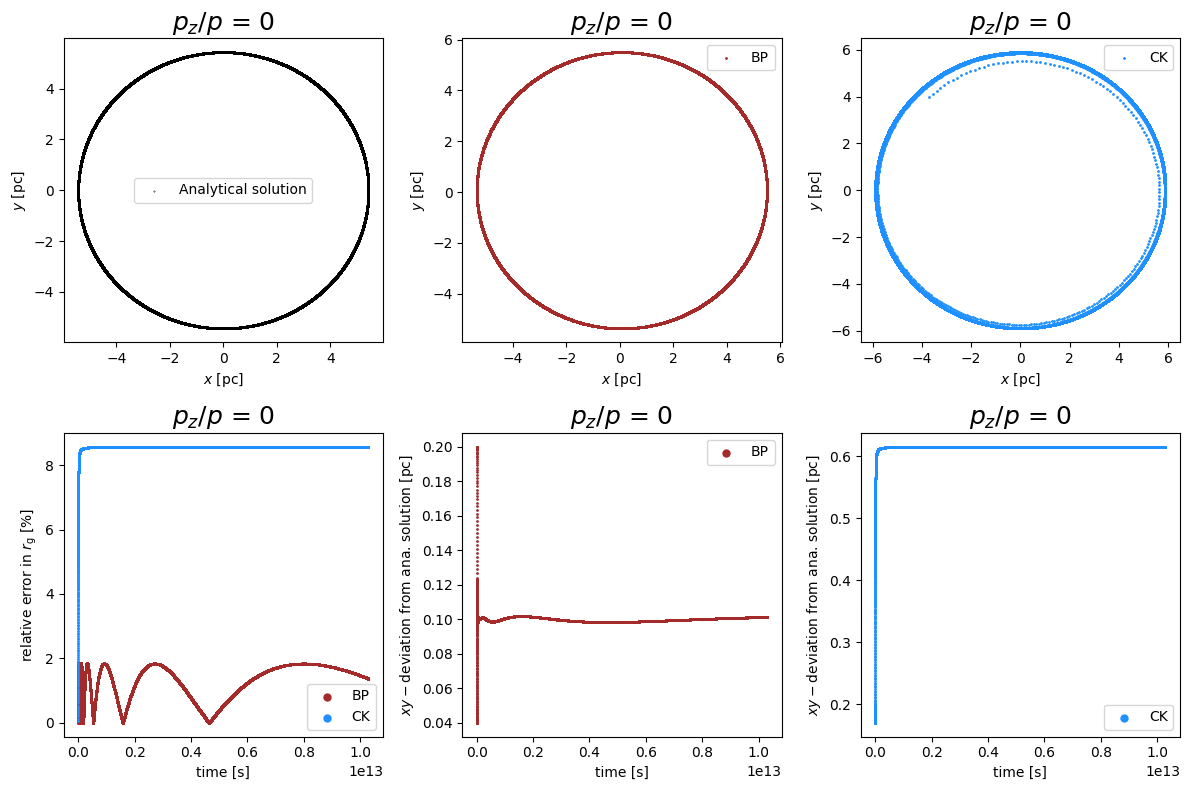

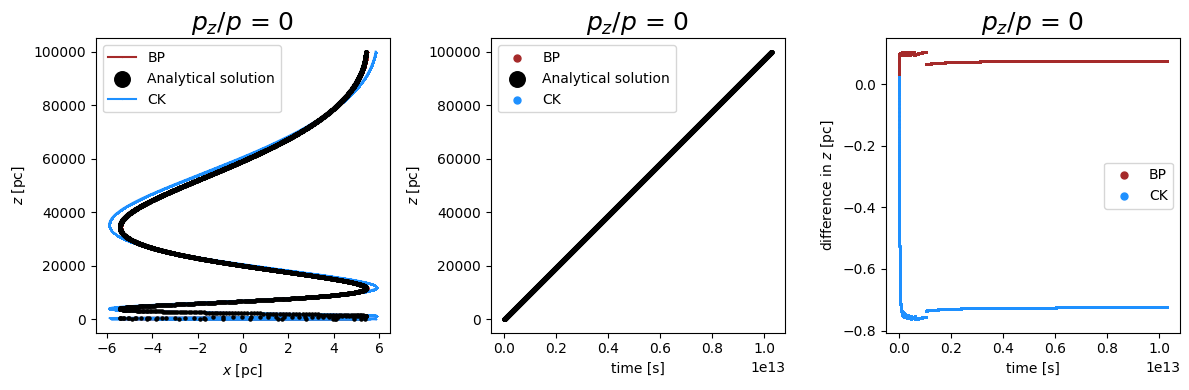

In [51]:
p_z = 0
p_z, r_g_0 = run_simulation('CK', p_z)
run_simulation('BP', p_z)
plot_figure_perp(max_trajectory, p_z, r_g_0, number_of_steps)
plot_figure_para(max_trajectory, p_z, r_g_0, number_of_steps)